# NMF Analysis

Performs a simple tf-idf of the question pairs and NMF dimension reduction to calculate cosine similarity of each question pair. The goal of the analysis is to see if the pairs labeled as duplicates have a distinctly different cosine similarity compared to those pairs marked as not duplicates.

In [1]:
# data manipulation
from utils import save, load
import pandas as pd
import numpy as np

# modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline

In [2]:
X_train = load('X_train')
y_train = load('y_train')
train_df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1))
train_df = train_df.rename(columns={0:'id', 1:'question1', 2:'question2', 3:'is_duplicate'})
train_df.head()

,id,question1,question2,is_duplicate
0,273307,Why do adult stores sell backdoor toys when I ...,How do I prepare and show them why my online s...,0
1,86159,"Looking through startup internships, I see "" n...",Why do many doctors who make $300k+ still comp...,0
2,174900,How do I prepare for CAT 2017 from August 2016?,How do I prepare for CAT 2017 (BBA student)?,1
3,32312,How can you train a Poodle/ Shih Tzu/ Maltese ...,How can you breed a Poodle/ Shih Tzu/ Maltese ...,0
4,366640,What's your favorite song now?,Music: What's your favourite song at the moment?,1


Let's make a stack of questions maintaining the `id` of the question pair.

In [3]:
question_df = train_df.loc[:, ['id', 'question1']]
question_df = question_df.append(train_df.loc[:,['id', 'question2']], sort=False)
question_df.loc[question_df['question1'].isna(), 'question1'] = question_df.loc[question_df['question1'].isna(), 'question2']
question_df = question_df.drop(columns='question2')
question_df = question_df.sort_values('id')
question_df.head(6)

,id,question1
175131,0,What is the step by step guide to invest in sh...
175131,0,What is the step by step guide to invest in sh...
11251,1,What is the story of Kohinoor (Koh-i-Noor) Dia...
11251,1,What would happen if the Indian government sto...
270031,2,How can I increase the speed of my internet co...
270031,2,How can Internet speed be increased by hacking...


Let's now calcualte the tf-idf term matrix.

In [4]:
tf = TfidfVectorizer(stop_words='english', token_pattern='\\b[a-zA-Z0-9][a-zA-Z0-9]+\\b')

question_tf = tf.fit_transform(question_df['question1'])

In [5]:
# first 10 terms
tf.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '000000',
 '00000000',
 '0000000000',
 '0000001',
 '00000074',
 '0000021210',
 '00001']

In [6]:
# last 10 terms
tf.get_feature_names()[-10:]

['zygote',
 'zygotene',
 'zyl',
 'zylber',
 'zynga',
 'zyrtec',
 'zyzz',
 'zz',
 'zzz',
 'zzzquil']

In [7]:
# total terms
len(tf.get_feature_names())

74795

Lots of words, but some cleanup will probably needed given the numbers.

Let's now reduce the 74,795 term matrix utilizing NMF.

In [8]:
def calc_NMF_sim(n_components, col_name, tf_df, df):
    nmf = NMF(n_components=n_components)

    nmf_topics = nmf.fit_transform(tf_df)

    odd_idx = [i for i in range(nmf_topics.shape[0]) if i % 2 == 1]
    even_idx = [i for i in range(nmf_topics.shape[0]) if i % 2 == 0]

    sim_list = [cosine_similarity(
                                    nmf_topics[odd_idx[i]].reshape(1,-1),
                                    nmf_topics[even_idx[i]].reshape(1,-1)
                )[0,0]
                for i in range(len(odd_idx))]

    df = pd.concat([df.sort_values('id'), pd.Series(sim_list)], axis=1)
    df = df.rename(columns={0:col_name})
    
    return df

In [9]:
train_df_cosine = calc_NMF_sim(5, 'cos_sim_5', question_tf, train_df.reset_index())
train_df_cosine = calc_NMF_sim(10, 'cos_sim_10', question_tf, train_df_cosine)
train_df_cosine = calc_NMF_sim(50, 'cos_sim_50', question_tf, train_df_cosine)
train_df_cosine = calc_NMF_sim(100, 'cos_sim_100', question_tf, train_df_cosine)

In [10]:
train_df_cosine.head()

,index,id,question1,question2,is_duplicate,cos_sim_5,cos_sim_10,cos_sim_50,cos_sim_100
0,0,273307,Why do adult stores sell backdoor toys when I ...,How do I prepare and show them why my online s...,0,0.632765,0.683539,0.291623,0.362805
1,1,86159,"Looking through startup internships, I see "" n...",Why do many doctors who make $300k+ still comp...,0,0.860158,0.305820,0.045665,0.023949
2,2,174900,How do I prepare for CAT 2017 from August 2016?,How do I prepare for CAT 2017 (BBA student)?,1,0.939776,0.637275,0.515736,0.447748
3,3,32312,How can you train a Poodle/ Shih Tzu/ Maltese ...,How can you breed a Poodle/ Shih Tzu/ Maltese ...,0,0.845662,0.407757,0.122281,0.960551
4,4,366640,What's your favorite song now?,Music: What's your favourite song at the moment?,1,0.993080,0.995284,0.956087,0.907705


We calcualted the cosine similarity for 5, 10, 50, and 100 dimensional dimensional NMF. Let's now plot the distribution for the duplicate pairs and not duplicate pairs. The goal is to see if there is a natural division based purely on the cosine similarity between the pair of questions.

## This seems off!!!

Need to figure out why there is so much overlap now. Let's ignore for now and see if the MVP model suffers the same.

''

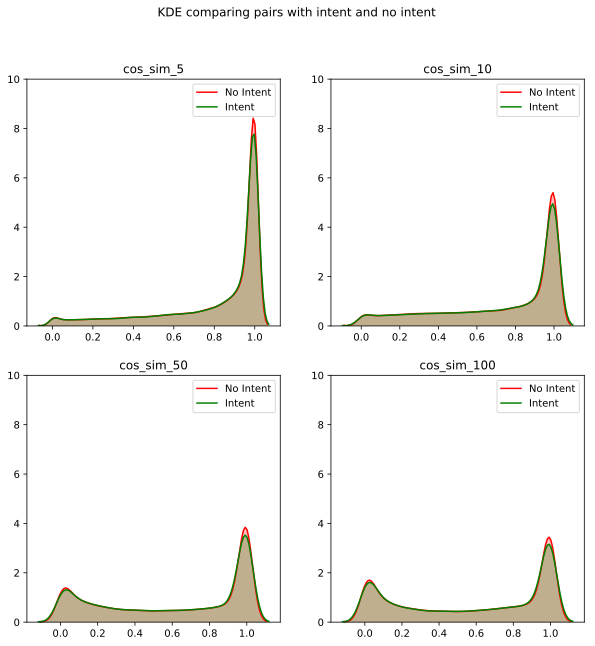

In [13]:
cols = ['cos_sim_5', 'cos_sim_10', 'cos_sim_50', 'cos_sim_100']
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(train_df_cosine.loc[train_df_cosine['is_duplicate'] == 0, cols[i]], 
                 shade=True, 
                 label = 'No Intent',
                 color = 'red')
    sns.kdeplot(train_df_cosine.loc[train_df_cosine['is_duplicate'] == 1, cols[i]], 
                 shade=True,
                 label = 'Intent',
                 color = 'green')
    plt.title(cols[i])
    plt.ylim(top=10)

# plt.xlabel('cosine similarity')
# plt.ylabel('density')
plt.suptitle('KDE comparing pairs with intent and no intent')
;

More of the duplicate pairs have a higher cosine similarity compared to the non-duplicate pairs. However, there is also significant overlap, which means finding the decision boundary will be difficult.

Let's take a look at the set of pairs marked as duplicates with a 0 cosine similarity with the NMF 100 transformation.

In [12]:
train_df_cosine[(train_df_cosine['is_duplicate'] == 1) & (train_df_cosine['cos_sim_100'] == 0)]

,index,id,question1,question2,is_duplicate,cos_sim_5,cos_sim_10,cos_sim_50,cos_sim_100
79,79,13748,How do I stop caring about what people think a...,What should I do in order not to care about wh...,1,0.000000,0.000000,0.000000,0.0
145,145,118129,What should I do if I have purple fingernails?,What does it mean when you have purple fingern...,1,0.020048,0.000000,0.016556,0.0
162,162,278931,What are the things that we can do to bring ch...,How can we improve India's current education s...,1,0.711567,0.685125,0.000092,0.0
629,629,343063,I just learned my maternal grandmother's mater...,"My great grandmother, the mother of my mother'...",1,0.000000,0.000000,0.067250,0.0
1205,1205,399336,What are some ways to become a good teacher?,How do I become a good teacher/tutor?,1,0.088763,0.067123,0.000000,0.0
1728,1728,114025,How did Nikola Tesla change the world?,How did Nikola Tesla changed the world?,1,0.719984,0.394131,0.021439,0.0
2643,2643,240823,What do you think of the Bharat Bandh on 28th ...,What do you think about opposition for Bharat ...,1,0.108224,0.062891,0.004489,0.0
2672,2672,334864,What is Bahá'í Faith?,What is your review of Bahá'í Faith?,1,0.402855,0.000000,0.000000,0.0
3339,3339,224974,What is the role of technology in investment b...,What is the role of Technology in an Investmen...,1,0.216324,0.197947,0.004982,0.0
4353,4353,37955,Why do people try to ask silly questions on Qu...,"How come people on Quora ask questions here, w...",1,0.366948,0.298658,0.000000,0.0


The first example is very confusing. This may be a result of the tf-idf calculation with default parameters is incorrect, or the cosine similarity is not the best metric. The next step would be to build a classification model using NMF or LDA topics for the pair of questions to predict whether or not the pair has the same intent.